<a href="https://colab.research.google.com/github/mukul-mschauhan/linear-regression/blob/main/Food_Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Genpact Machine Learning Hackathon

Your client is a meal delivery company which operates in multiple cities. They have various **fulfillment centers** in these cities for dispatching meal orders to their customers. The client wants you to help these centers with **demand forecasting** for upcoming weeks so that these centers will plan the stock of raw materials accordingly.

The replenishment of majority of raw materials is done on weekly basis and since the raw material is perishable, the procurement planning is of utmost importance. Secondly, **staffing of the centers** is also one area wherein accurate demand forecasts are really helpful. Given the following information, the task is to **predict the demand for the next 10 weeks** (Weeks: 146-155) for the center-meal combinations in the test set:

* Historical data of demand for a product-center combination (Weeks: 1 to 145)
* Product(Meal) features such as category, sub-category, current price and discount
* Information for fulfillment center like center area, city information etc.

In [1]:
# Import the Libbraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test_QoiMO9B.csv")
meal = pd.read_csv("/content/meal_info.csv")
centres = pd.read_csv("/content/fulfilment_center_info.csv")
submission = pd.read_csv("/content/sample_submission_hSlSoT6.csv")

In [3]:
# Check the Dataset
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [5]:
train.columns, test.columns, centres.columns, meal.columns

(Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
        'emailer_for_promotion', 'homepage_featured', 'num_orders'],
       dtype='object'),
 Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
        'emailer_for_promotion', 'homepage_featured'],
       dtype='object'),
 Index(['center_id', 'city_code', 'region_code', 'center_type', 'op_area'], dtype='object'),
 Index(['meal_id', 'category', 'cuisine'], dtype='object'))

In [7]:
# Combine Train and Test
combined = pd.concat([train, test], ignore_index = True)
combined = pd.merge(combined, centres, how = "left", on = "center_id")
combined = pd.merge(combined, meal, how = "left", on = "meal_id")

In [8]:
train.shape, test.shape, meal.shape, centres.shape, combined.shape

((456548, 9), (32573, 8), (51, 3), (77, 5), (489121, 15))

In [41]:
combined.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,log_target,price_diff,price_cat,marketing
0,1379560,1,55,1885,136.83,152.29,0,0,177.0,647,56,TYPE_C,2.0,Beverages,Thai,5.176150,15.46,Addnl_Chgs,0
1,1466964,1,55,1993,136.83,135.83,0,0,270.0,647,56,TYPE_C,2.0,Beverages,Thai,5.598422,-1.00,Discount,0
2,1346989,1,55,2539,134.86,135.86,0,0,189.0,647,56,TYPE_C,2.0,Beverages,Thai,5.241747,1.00,Taxes,0
3,1338232,1,55,2139,339.50,437.53,0,0,54.0,647,56,TYPE_C,2.0,Beverages,Indian,3.988984,98.03,Addnl_Chgs,0
4,1448490,1,55,2631,243.50,242.50,0,0,40.0,647,56,TYPE_C,2.0,Beverages,Indian,3.688879,-1.00,Discount,0


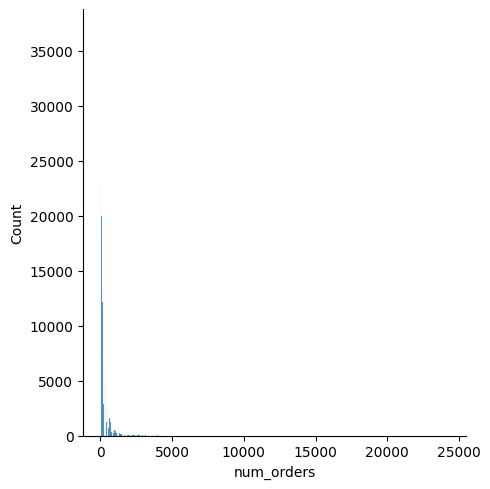

In [11]:
# Target Variable

sns.displot(x = "num_orders", data = combined)
plt.show()

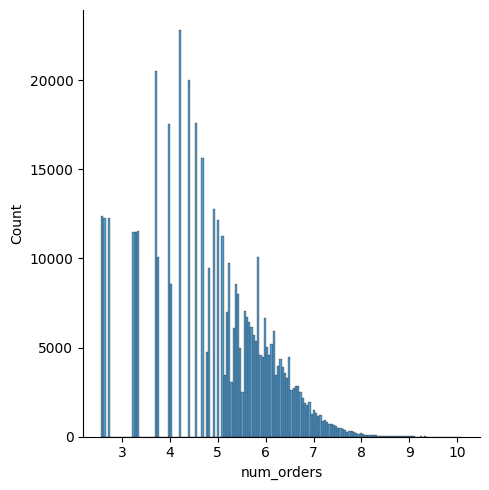

In [12]:
sns.displot(np.log(combined.num_orders))
plt.show()

In [13]:
np.log(combined.num_orders).describe()

,num_orders
count,456548.000000
mean,4.873096
std,1.219120
min,2.564949
25%,3.988984
50%,4.912655
75%,5.780744
max,10.098190


In [14]:
combined["log_target"] = np.log(combined.num_orders)

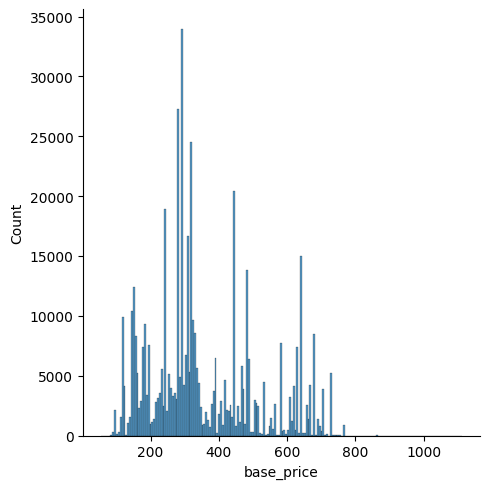

In [16]:
# Base Price

sns.displot(combined.base_price)
plt.show()

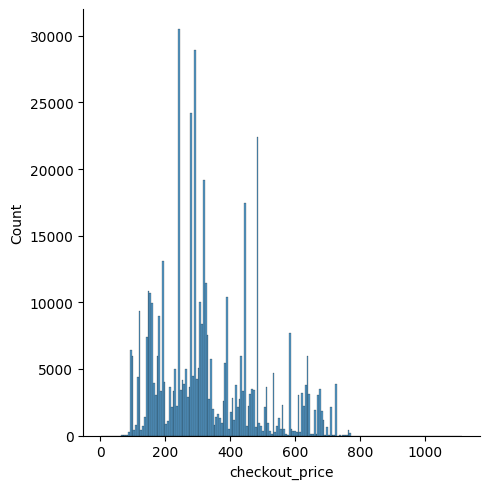

In [17]:
sns.displot(combined.checkout_price)
plt.show()

In [28]:
# Treatment of Prices
combined["price_diff"] = combined.base_price - combined.checkout_price

def price(x):
  if x<0:
    return("Discount")
  elif x<=10:
    return("Taxes")
  else:
    return("Addnl_Chgs")

In [29]:
combined["price_cat"] = combined.price_diff.apply(price)

In [30]:
combined.price_cat.value_counts(normalize = True)

,proportion
price_cat,
Taxes,0.495810
Discount,0.255638
Addnl_Chgs,0.248552


In [36]:
combined.loc[:, ["price_diff", "num_orders"]].corr()

,price_diff,num_orders
price_diff,1.00000,0.15295
num_orders,0.15295,1.00000


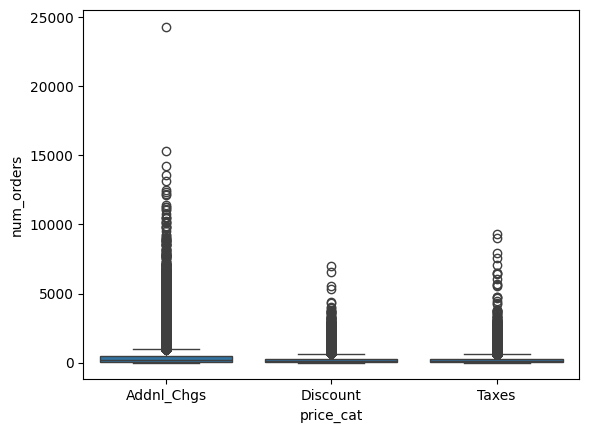

In [37]:
sns.boxplot(x="price_cat", y = "num_orders", data = combined)
plt.show()

In [39]:
# Social Medial
combined["marketing"] = combined.emailer_for_promotion+\
combined.homepage_featured

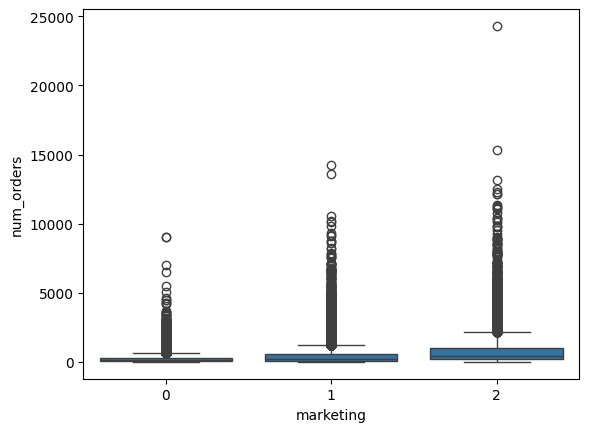

In [40]:
sns.boxplot(x = "marketing", y = "num_orders", data = combined)
plt.show()

<Axes: xlabel='cuisine'>

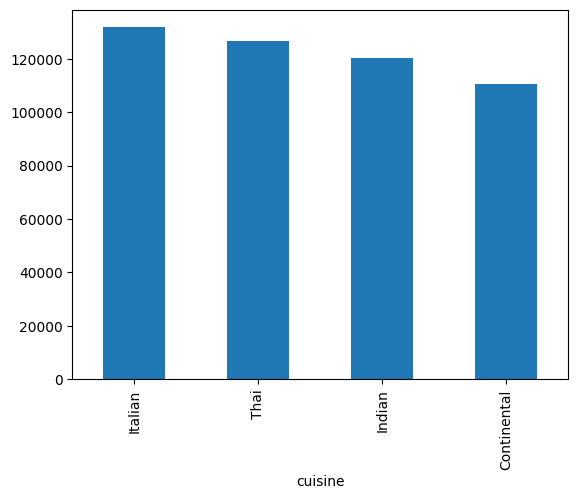

In [43]:
# Cuisine
combined.cuisine.value_counts().plot(kind = "bar")

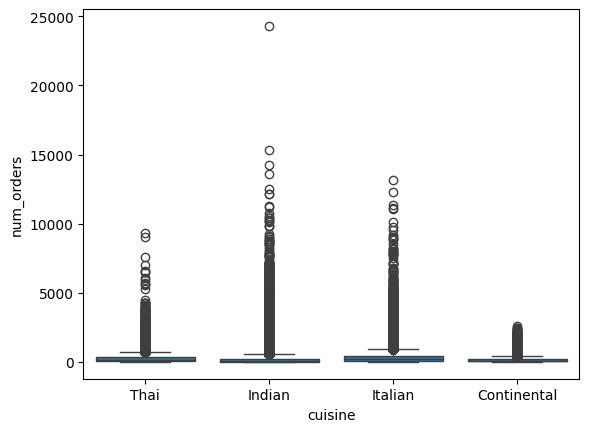

In [44]:
sns.boxplot(x = "cuisine", y = "num_orders", data = combined)
plt.show()

<Axes: xlabel='category'>

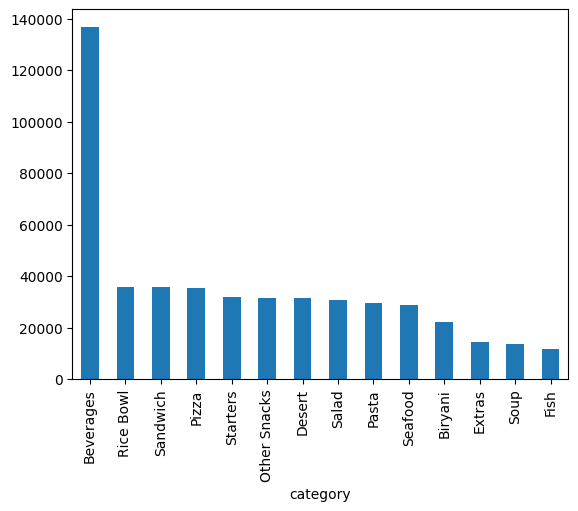

In [45]:
# Cuisine
combined.category.value_counts().plot(kind = "bar")

# Top 5: Beverages, Ricebowl, Sandwich, Pizza, Starters

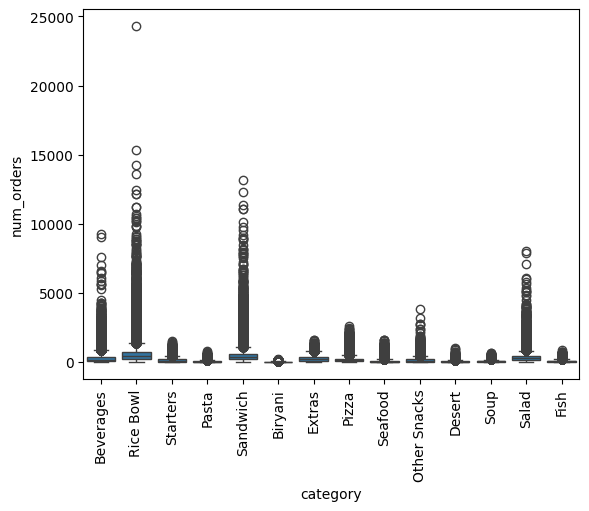

In [48]:
sns.boxplot(x = "category", y = "num_orders", data = combined)
plt.xticks(rotation = 90)
plt.show()

# Salad, Beverages, Ricebowl, Sandwich, Other Snacks

In [49]:
combined.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,log_target,price_diff,price_cat,marketing
0,1379560,1,55,1885,136.83,152.29,0,0,177.0,647,56,TYPE_C,2.0,Beverages,Thai,5.176150,15.46,Addnl_Chgs,0
1,1466964,1,55,1993,136.83,135.83,0,0,270.0,647,56,TYPE_C,2.0,Beverages,Thai,5.598422,-1.00,Discount,0
2,1346989,1,55,2539,134.86,135.86,0,0,189.0,647,56,TYPE_C,2.0,Beverages,Thai,5.241747,1.00,Taxes,0
3,1338232,1,55,2139,339.50,437.53,0,0,54.0,647,56,TYPE_C,2.0,Beverages,Indian,3.988984,98.03,Addnl_Chgs,0
4,1448490,1,55,2631,243.50,242.50,0,0,40.0,647,56,TYPE_C,2.0,Beverages,Indian,3.688879,-1.00,Discount,0


In [58]:
combined.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,log_target,price_diff,price_cat,marketing,radii
0,1379560,1,55,1885,136.83,152.29,0,0,177.0,647,56,TYPE_C,2.0,Beverages,Thai,5.176150,15.46,Addnl_Chgs,0,0.797885
1,1466964,1,55,1993,136.83,135.83,0,0,270.0,647,56,TYPE_C,2.0,Beverages,Thai,5.598422,-1.00,Discount,0,0.797885
2,1346989,1,55,2539,134.86,135.86,0,0,189.0,647,56,TYPE_C,2.0,Beverages,Thai,5.241747,1.00,Taxes,0,0.797885
3,1338232,1,55,2139,339.50,437.53,0,0,54.0,647,56,TYPE_C,2.0,Beverages,Indian,3.988984,98.03,Addnl_Chgs,0,0.797885
4,1448490,1,55,2631,243.50,242.50,0,0,40.0,647,56,TYPE_C,2.0,Beverages,Indian,3.688879,-1.00,Discount,0,0.797885


In [56]:
import scipy.stats as stats
import math

def radii(x):
  return(np.sqrt(x/math.pi))

combined["radii"] = combined.op_area.apply(radii)

In [57]:
combined.loc[:, ["radii", "num_orders"]].corr()

,radii,num_orders
radii,1.00000,0.17253
num_orders,0.17253,1.00000


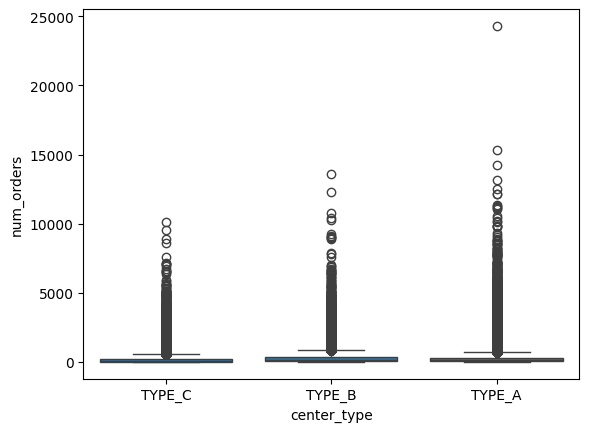

In [60]:
# Center Type, Region code and City Code

sns.boxplot(x = "center_type", y = "num_orders", data = combined)
plt.show()

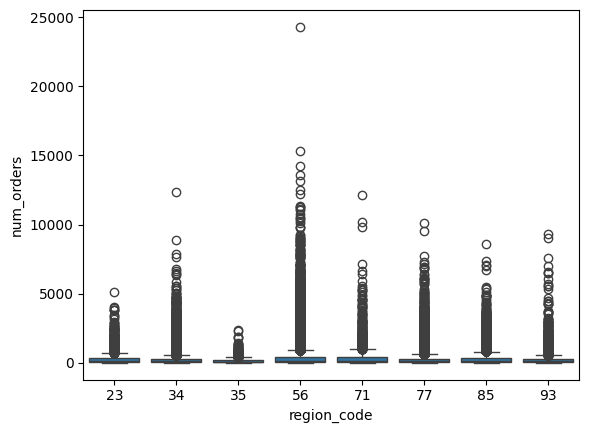

In [61]:
sns.boxplot(x = "region_code", y = "num_orders", data = combined)
plt.show()

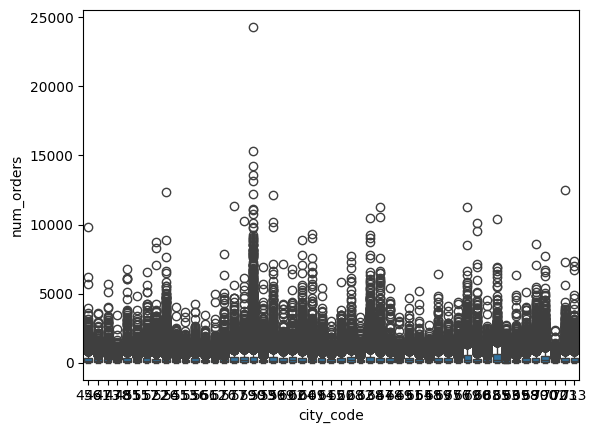

In [62]:
sns.boxplot(x = "city_code", y = "num_orders", data = combined)
plt.show()

In [66]:
combined.city_code.value_counts()[:5].index

Index([590, 526, 638, 522, 517], dtype='int64', name='city_code')

In [69]:
def year(x):
  if x<=52:
    return("Year1")
  elif x<=104:
    return("Year2")
  else:
    return("Year3")

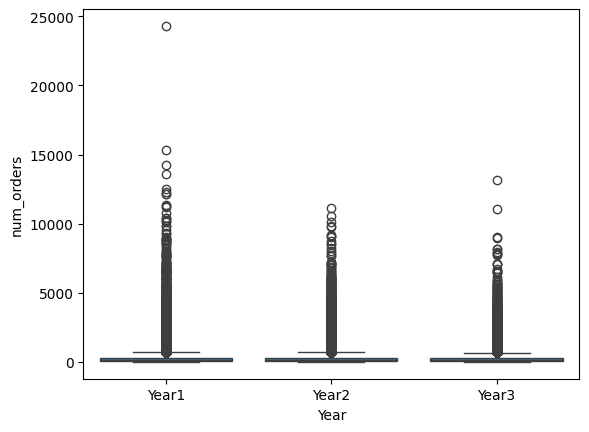

In [71]:
combined["Year"] = combined.week.apply(year)

sns.boxplot(x = "Year", y = "num_orders", data = combined)
plt.show()

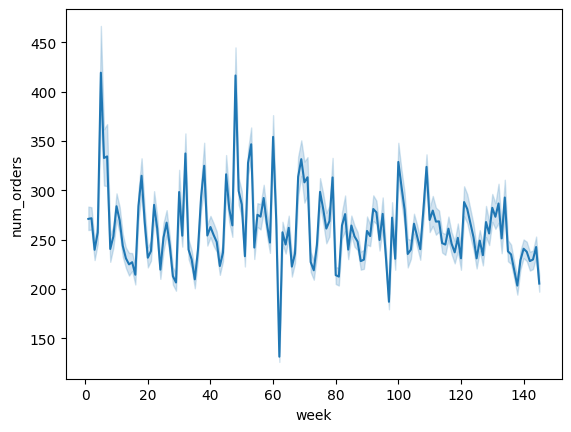

In [73]:
# max week  = 155

sns.lineplot(x = "week", y = "num_orders", data = combined)
plt.show()

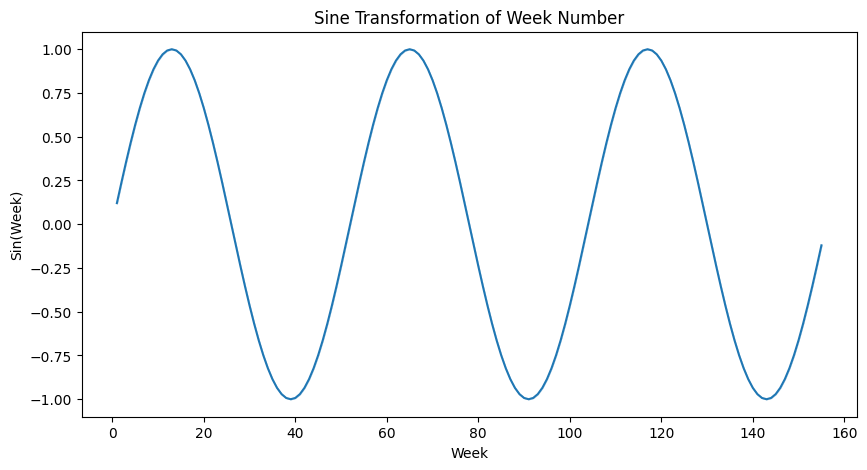

In [75]:
# Assuming 'combined' DataFrame is already created as in the provided code.

# Create a new feature 'sin_week' representing the sine transformation of the week number.
combined['sin_week'] = np.sin(2 * np.pi * combined['week'] / 52)  # 52 weeks in a year
combined['cos_week'] = np.cos(2 * np.pi * combined['week'] / 52)

# You can visualize the effect of the sine transformation.
plt.figure(figsize=(10, 5))
sns.lineplot(x='week', y='sin_week', data=combined)
plt.title('Sine Transformation of Week Number')
plt.xlabel('Week')
plt.ylabel('Sin(Week)')
plt.show()

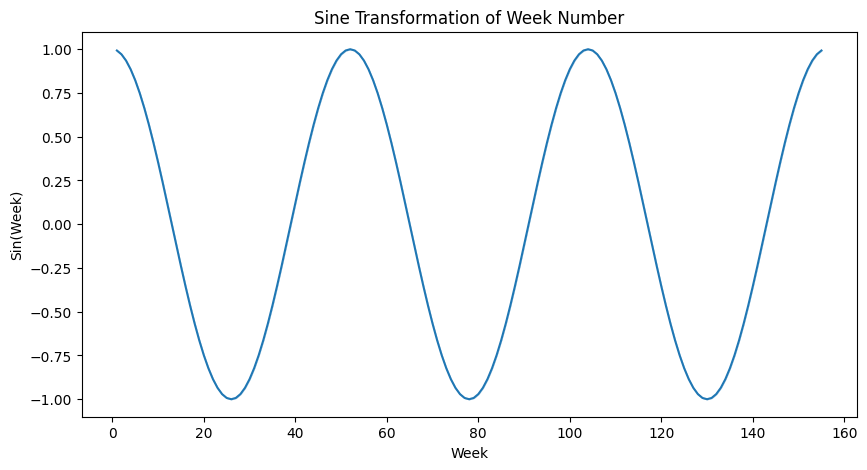

In [76]:
# You can visualize the effect of the sine transformation.
plt.figure(figsize=(10, 5))
sns.lineplot(x='week', y='cos_week', data=combined)
plt.title('Sine Transformation of Week Number')
plt.xlabel('Week')
plt.ylabel('Sin(Week)')
plt.show()

In [78]:
# Dropping 4 Features
combined.drop(["emailer_for_promotion",
               "homepage_featured", "id", "week"], axis = 1, inplace = True)

### Feature Engineering

* center ID wise num_orders
* meal_id wise num_orders
* city code wise num_orders
* region_code wise num_orders
* center type wise num_orders
* category wise num_orders




In [80]:
combined.columns

Index(['center_id', 'meal_id', 'checkout_price', 'base_price', 'num_orders',
       'city_code', 'region_code', 'center_type', 'op_area', 'category',
       'cuisine', 'log_target', 'price_diff', 'price_cat', 'marketing',
       'radii', 'Year', 'sin_week', 'cos_week'],
      dtype='object')

In [83]:
# center wise
combined["magic1"]=  combined.groupby("center_id")["num_orders"].transform("min")
combined["magic2"]=  combined.groupby("center_id")["num_orders"].transform("mean")
combined["magic3"]=  combined.groupby("center_id")["num_orders"].transform("median")
combined["magic4"]=  combined.groupby("center_id")["num_orders"].transform("std")
combined["magic5"]=  combined.groupby("center_id")["num_orders"].transform("max")

In [84]:
# meal_id
combined["magic6"]=  combined.groupby("meal_id")["num_orders"].transform("min")
combined["magic7"]=  combined.groupby("meal_id")["num_orders"].transform("mean")
combined["magic8"]=  combined.groupby("meal_id")["num_orders"].transform("median")
combined["magic9"]=  combined.groupby("meal_id")["num_orders"].transform("std")
combined["magic10"]=  combined.groupby("meal_id")["num_orders"].transform("max")

In [85]:
# city_code
combined["magic11"]= combined.groupby("city_code")["num_orders"].transform("min")
combined["magic12"]= combined.groupby("city_code")["num_orders"].transform("mean")
combined["magic13"]= combined.groupby("city_code")["num_orders"].transform("median")
combined["magic14"]= combined.groupby("city_code")["num_orders"].transform("std")
combined["magic15"]= combined.groupby("city_code")["num_orders"].transform("max")

In [86]:
# region_code

combined["magic16"]= combined.groupby("region_code")["num_orders"].transform("min")
combined["magic17"]= combined.groupby("region_code")["num_orders"].transform("mean")
combined["magic18"]= combined.groupby("region_code")["num_orders"].transform("median")
combined["magic19"]= combined.groupby("region_code")["num_orders"].transform("std")
combined["magic20"]= combined.groupby("region_code")["num_orders"].transform("max")


In [87]:
# category

combined["magic21"]= combined.groupby("category")["num_orders"].transform("min")
combined["magic22"]= combined.groupby("category")["num_orders"].transform("mean")
combined["magic23"]= combined.groupby("category")["num_orders"].transform("median")
combined["magic24"]= combined.groupby("category")["num_orders"].transform("std")
combined["magic25"]= combined.groupby("category")["num_orders"].transform("max")


* Category Wise CheckOut Price
* centerid wise check out price
* meal_id wise checkout price
* city code wise checkout price
* region code wise checkout price

In [90]:
# Category Wise Check Out Price
combined["magic26"]= combined.groupby("category")["checkout_price"].transform("min")
combined["magic27"]= combined.groupby("category")["checkout_price"].transform("mean")
combined["magic28"]= combined.groupby("category")["checkout_price"].transform("median")
combined["magic29"]= combined.groupby("category")["checkout_price"].transform("std")
combined["magic30"]= combined.groupby("category")["checkout_price"].transform("max")


In [91]:
# Center-ID vs Check Out Price
combined["magic31"]= combined.groupby("center_id")["checkout_price"].transform("min")
combined["magic32"]= combined.groupby("center_id")["checkout_price"].transform("mean")
combined["magic33"]= combined.groupby("center_id")["checkout_price"].transform("median")
combined["magic34"]= combined.groupby("center_id")["checkout_price"].transform("std")
combined["magic35"]= combined.groupby("center_id")["checkout_price"].transform("max")


In [92]:
# Meal-ID vs Check Out Price
combined["magic36"]= combined.groupby("meal_id")["checkout_price"].transform("min")
combined["magic37"]= combined.groupby("meal_id")["checkout_price"].transform("mean")
combined["magic38"]= combined.groupby("meal_id")["checkout_price"].transform("median")
combined["magic39"]= combined.groupby("meal_id")["checkout_price"].transform("std")
combined["magic40"]= combined.groupby("meal_id")["checkout_price"].transform("max")


In [93]:
# Region-Code vs Check Out Price
combined["magic41"]= combined.groupby("region_code")["checkout_price"].transform("min")
combined["magic42"]= combined.groupby("region_code")["checkout_price"].transform("mean")
combined["magic43"]= combined.groupby("region_code")["checkout_price"].transform("median")
combined["magic44"]= combined.groupby("region_code")["checkout_price"].transform("std")
combined["magic45"]= combined.groupby("region_code")["checkout_price"].transform("max")


In [94]:
# City-Code vs Check Out Price
combined["magic46"]= combined.groupby("city_code")["checkout_price"].transform("min")
combined["magic47"]= combined.groupby("city_code")["checkout_price"].transform("mean")
combined["magic48"]= combined.groupby("city_code")["checkout_price"].transform("median")
combined["magic49"]= combined.groupby("city_code")["checkout_price"].transform("std")
combined["magic50"]= combined.groupby("city_code")["checkout_price"].transform("max")


In [96]:
# Split the Data into train and test

newtrain = combined.loc[0:train.shape[0]-1, :]
newtest = combined.loc[train.shape[0]:, :]

train.shape, test.shape, newtrain.shape, newtest.shape

newtest.drop("num_orders", axis = 1, inplace = True)

In [97]:
train.shape, test.shape, newtrain.shape, newtest.shape

((456548, 9), (32573, 8), (456548, 69), (32573, 68))

## Statistical Analysis

In [101]:
pd.set_option('display.max_columns', 100)
newtrain.select_dtypes(include = np.number).columns

Index(['center_id', 'meal_id', 'checkout_price', 'base_price', 'num_orders',
       'city_code', 'region_code', 'op_area', 'log_target', 'price_diff',
       'marketing', 'radii', 'sin_week', 'cos_week', 'magic1', 'magic2',
       'magic3', 'magic4', 'magic5', 'magic6', 'magic7', 'magic8', 'magic9',
       'magic10', 'magic11', 'magic12', 'magic13', 'magic14', 'magic15',
       'magic16', 'magic17', 'magic18', 'magic19', 'magic20', 'magic21',
       'magic22', 'magic23', 'magic24', 'magic25', 'magic26', 'magic27',
       'magic28', 'magic29', 'magic30', 'magic31', 'magic32', 'magic33',
       'magic34', 'magic35', 'magic36', 'magic37', 'magic38', 'magic39',
       'magic40', 'magic41', 'magic42', 'magic43', 'magic44', 'magic45',
       'magic46', 'magic47', 'magic48', 'magic49', 'magic50'],
      dtype='object')

In [102]:
nums = ['magic1', 'magic2',
       'magic3', 'magic4', 'magic5', 'magic6', 'magic7', 'magic8', 'magic9',
       'magic10', 'magic11', 'magic12', 'magic13', 'magic14', 'magic15',
       'magic16', 'magic17', 'magic18', 'magic19', 'magic20', 'magic21',
       'magic22', 'magic23', 'magic24', 'magic25', 'magic26', 'magic27',
       'magic28', 'magic29', 'magic30', 'magic31', 'magic32', 'magic33',
       'magic34', 'magic35', 'magic36', 'magic37', 'magic38', 'magic39',
       'magic40', 'magic41', 'magic42', 'magic43', 'magic44', 'magic45',
       'magic46', 'magic47', 'magic48', 'magic49', 'magic50']

In [103]:
# Ho: Predictor and Target are Independent
# Ha: Ho is False

pvalue = []

for i in nums:
  teststats, pval = stats.ttest_ind(newtrain.loc[:, i],
                                    newtrain.num_orders)
  pvalue.append(pval)

In [115]:
pvals = pd.DataFrame(pvalue, index = nums, columns = ["PValue"])
insignificant = pvals.loc[pvals.PValue>0.05].index

In [112]:
# Price_Diff vs target
# Ho: Price Diff has no relation with the Num_Orders
# Ha: No of Orders depend on Price Diff...

teststats, pval = stats.ttest_ind(newtrain.loc[:, "price_diff"],
                                  newtrain.num_orders)
print(teststats, pval)

-406.4703738608052 0.0


In [120]:
# Radii and Op Area
# Ho: Op Area has no relation with the Num_Orders
# Ha: No of Orders depend on Op Area...

teststats, pval = stats.ttest_ind(newtrain.loc[:, "op_area"],
                                  newtrain.num_orders)
print(teststats, pval)

teststats, pval = stats.ttest_ind(newtrain.loc[:, "radii"],
                                  newtrain.num_orders)
print(teststats, pval)

-439.9423098622263 0.0
-444.98491992280447 0.0


## Cat Vars vs Num

In [121]:
newtrain.select_dtypes(include = "object").columns

Index(['center_type', 'category', 'cuisine', 'price_cat', 'Year'], dtype='object')

In [122]:
# Anova
# Ho: Predictors and Target are Independent
# Ha: Ho is False
import statsmodels.formula.api as sfa
from statsmodels.stats.anova import anova_lm

model = sfa.ols("num_orders~center_type+category+cuisine+price_cat+Year",
                data = newtrain).fit()

print(anova_lm(model))

                   df        sum_sq       mean_sq             F        PR(>F)
center_type       2.0  6.090329e+08  3.045165e+08   2802.233558  0.000000e+00
category         13.0  1.343108e+10  1.033160e+09   9507.383881  0.000000e+00
cuisine           3.0  4.510531e+09  1.503510e+09  13835.663300  0.000000e+00
price_cat         2.0  3.397928e+09  1.698964e+09  15634.275816  0.000000e+00
Year              2.0  7.186426e+06  3.593213e+06     33.065609  4.373492e-15
Residual     456525.0  4.961021e+10  1.086692e+05           NaN           NaN


In [123]:
# Drop the Insignificant Features from the Train and Test

newtrain.drop(insignificant, axis = 1, inplace = True)
newtest.drop(insignificant, axis = 1, inplace = True)

In [146]:
newtrain.drop(['center_id', 'meal_id', 'city_code', 'region_code',
               "category"], axis = 1, inplace = True)

newtest.drop(['center_id', 'meal_id', 'city_code', 'region_code',
              'category'], axis = 1, inplace = True)

KeyError: "['center_id', 'meal_id', 'city_code', 'region_code', 'category'] not found in axis"

### Modeling

* Split the Data in X and y
* K Fold CV
* Prediction
* Submission

In [147]:
# Split the Data in X and y
X = newtrain.drop(["num_orders", "log_target", "Year"], axis = 1)
y = newtrain.num_orders
logy = newtrain.log_target
dummyx = pd.get_dummies(X, drop_first=True)
newtest.drop("log_target",axis = 1, inplace = True)

In [148]:
newtest.drop("Year", axis = 1, inplace=True)
dummytest = pd.get_dummies(newtest, drop_first = True)

In [149]:
# K Fold Model
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import root_mean_squared_log_error, root_mean_squared_error
kfold = KFold(n_splits = 5, shuffle = True)

lr = LinearRegression()
rf = RandomForestRegressor()
gbm = GradientBoostingRegressor()

In [150]:
pred = []
for train_index, test_index in kfold.split(dummyx, y):
  xtrain = dummyx.iloc[train_index, :]
  xtest = dummyx.iloc[test_index, :]
  ytrain = y.iloc[train_index]
  ytest = y.iloc[test_index]
  # Modelling and Prediction
  #pred_lr = lr.fit(xtrain, ytrain).predict(xtest)
  # Cost Function
  #cost = root_mean_squared_error(ytest, pred_lr)
  #print(cost)

  # Final Prediction
  pred.append(lr.fit(xtrain, ytrain).predict(dummytest))

In [151]:
submission = pd.DataFrame(pred).T.mean(axis = 1)

In [152]:
# Sample
sample = pd.read_csv("/content/sample_submission_hSlSoT6.csv")

In [160]:
# Save the Predictions
sample["num_orders"] = np.abs(submission)
# Export it to csv
sample.to_csv("LRModel.csv", index = False) # 106

In [162]:
# Target Variable is Logy
pred = []
for train_index, test_index in kfold.split(dummyx, logy):
  xtrain = dummyx.iloc[train_index, :]
  xtest = dummyx.iloc[test_index, :]
  ytrain = logy.iloc[train_index]
  ytest = logy.iloc[test_index]
# Model and Prediction
  pred_lr = lr.fit(xtrain, ytrain).predict(xtest)
  cost = root_mean_squared_log_error(ytest, pred_lr)
  print(cost)
# Final Prediction
  pred.append(lr.predict(dummytest))

0.12555580938320252
0.12466305183153918
0.1251009748833096
0.1252244404355564
0.1250314988546363


In [166]:
# Save the Predictions
submission = pd.DataFrame(np.exp(pred)).T.mean(axis = 1)

sample["num_orders"] = np.abs(submission)
# Export it to csv
sample.to_csv("LRLOGModel.csv", index = False) # 65

In [167]:
# Target Variable is Logy
pred = []
for train_index, test_index in kfold.split(dummyx, logy):
  xtrain = dummyx.iloc[train_index, :]
  xtest = dummyx.iloc[test_index, :]
  ytrain = logy.iloc[train_index]
  ytest = logy.iloc[test_index]
# Model and Prediction
  pred_lr = rf.fit(xtrain, ytrain).predict(xtest)
  cost = root_mean_squared_log_error(ytest, pred_lr)
  print(cost)
# Final Prediction
  pred.append(rf.predict(dummytest))

0.09810017048455325
0.09808417132134714
0.09797937675106864
0.0980293417733256
0.09816812225002862


In [169]:
submission = pd.DataFrame(np.exp(pred)).T.mean(axis = 1)

sample["num_orders"] = np.abs(submission)
# Export it to csv
sample.to_csv("PradeepjiModel.csv", index = False) # 53.66